In [1]:
all.start.time = Sys.time()
options(warn=-1)

# import required library
if (!require(dummies)) {
    install.packages("dummies")
}
if (!require(DAAG)) {
    install.packages("DAAG")
}
if (!require(xgboost)) {
    install.packages("xgboost")
}
if (!require(randomForest)) {
    install.packages("randomForest")
}
if (!require(gbm)) {
    install.packages("gbm")
}
if (!require(glmnet)) {
    install.packages("glmnet")
}

library(xgboost)       # XGBoost model
library(randomForest)  # Random Forest model
library(gbm)           # GBM model
library(dummies)       # Dummy variable
library(DAAG)          # Cross-Validation
library(glmnet)        # Logistic regression with Lasso

Loading required package: dummies
dummies-1.5.6 provided by Decision Patterns

Loading required package: DAAG
Loading required package: lattice
Loading required package: xgboost
Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: gbm
Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:DAAG’:

    lung

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1
Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



In [2]:
#######################################################
# temporarily code
# load the data set
data = read.csv('./data/loan.csv')
tmp = read.csv('./data/2016AllData.csv')

# change factor into numeric
tmp$int_rate = as.numeric(sub("%", "", tmp$int_rate))
tmp$revol_util = as.numeric(sub("%", "", tmp$revol_util))

# merge together
data = rbind(data, tmp)
rm(tmp)

# random sample 75% as training and 25% as test set
set.seed(5000)
idx = sample(1:nrow(data), floor(nrow(data) * 0.75), replace=FALSE)
train = data[idx, ]
test = data[-idx, ]

# change the loan status
default.y = c('Default', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 
              'Does not meet the credit policy. Status:Charged Off')
test.y = ifelse(test$loan_status %in% default.y, 1, 0)
test = test[, names(test) != "loan_status"]

rm(data)

In [3]:
# # -----------------------------------------------------------
# # load the data set
# train = read.csv('./train.csv')
# test = read.csv('./test.csv')

# the ID as the first column
TEST_predict = data.frame(test[, "id"])  
# the SalePrice was set to 0.0 initially
TEST_predict['prob'] = matrix(rep(0.0, nrow(test))) 
# reset the column names of final results
colnames(TEST_predict) = c("id", "prob")  

In [4]:
# -----------------------------------------------------------
# Pre-processing and feature selection

# change the loan status
default.y = c('Default', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 
              'Does not meet the credit policy. Status:Charged Off')
train.y = ifelse(train$loan_status %in% default.y, 1, 0)

# -----------------------------------------------------------
# drop columns that have too many missing values
drop.names = c("mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", 
               "annual_inc_joint", "dti_joint", "open_acc_6m", "open_il_6m", "open_il_12m", 
               "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", 
               "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m")
train = train[, !(names(train) %in% drop.names)]
test = test[, !(names(test) %in% drop.names)]

# Transform categorical feature into numerical feature
train$sub_grade = as.numeric(train$sub_grade)
test$sub_grade = as.numeric(test$sub_grade)

# -----------------------------------------------------------
# Drop useless features
# drop useless categorical features
drop.names = c("emp_title", "issue_d", "pymnt_plan", "url", "desc", "title", "zip_code", "addr_state", 
               "earliest_cr_line", "last_pymnt_d", "next_pymnt_d", "last_credit_pull_d", "application_type", 
               "verification_status_joint", "grade")
train = train[, !(names(train) %in% drop.names)]
test = test[, !(names(test) %in% drop.names)]

# drop useless numerical features
drop.names = c("id", "member_id", "policy_code")
train = train[, !(names(train) %in% drop.names)]
test = test[, !(names(test) %in% drop.names)]

# -----------------------------------------------------------
# Data Structures
# find all categorical and numerical variables
data.type = sapply(test, class)
cat.var = names(test)[which(data.type == 'factor')]
num.var = names(test)[which((data.type == 'integer') | (data.type == 'numeric'))]

# -----------------------------------------------------------
# Fill NA values
# create new feature named "NA" for categorical variables
for (i in cat.var) {
    train[, i] = addNA(train[, i])
    test[, i] = addNA(test[, i])
}

# create new feature using the median value for numerical variables
for (i in num.var) {
    na.id = is.na(train[, i])
    tmp.median = median(train[, i], na.rm=TRUE)
    train[which(na.id), i] = tmp.median
    
    na.id = is.na(test[, i])
    test[which(na.id), i] = tmp.median
}

# -----------------------------------------------------------
# Skewness
skew = c('installment', 'annual_inc', 'dti', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 
         'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
         'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'tot_coll_amt', 'tot_cur_bal',
         'total_rev_hi_lim')

for (i in skew){
    train[, i] = log(train[, i] + 2)
    test[, i] = log(test[, i] + 2)
}

# -----------------------------------------------------------
# Dummy Variables
data = rbind(train[, names(test)], test)

# save memory
rm(train, test)

# create dummy variables
dummy.var = data.frame(dummy.data.frame(data[, cat.var], sep='.'))
data = cbind(data, dummy.var)

# drop original categorical variables
data = data[ , !(names(data) %in% cat.var)]

# split into train and test data set
train = data[1: length(train.y), ]
test = data[(length(train.y) + 1): nrow(data), ]
train['loan_status'] = train.y

# save memory
rm(data)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2571713,137.4,6379917,340.8,5746928,307
Vcells,110539794,843.4,230816771,1761.0,288485433,2201


In [5]:
scale = function(score) {
    # function to scale the score
    score[which(score < 1e-15)] = 1e-15
    score[which(score > 1 - 1e-15)] = 1 - 1e-15
    score
}

# Logistic Model

In [6]:
start.time = Sys.time()  # get time information

# fit the logistic model
log.model = glm(loan_status ~ ., data=train, family=binomial)

end.time = Sys.time()
cat("Logistic Regression Model\n")
cat('Start time:\t', as.character(start.time), '\n')
cat('End time:\t', as.character(end.time), '\n')
cat('Total time:\t', end.time - start.time, '\n')

Logistic Regression Model
Start time:	 2017-04-06 13:09:32 
End time:	 2017-04-06 13:21:35 
Total time:	 12.05965 


In [7]:
# calculate log-loss
test.y.hat = predict(log.model, test, type="response")
test.y.hat = scale(test.y.hat)

# # make submission file
# TEST_predict$prob = test.y.hat
# write.table(TEST_predict, './mysubmission1.txt', row.names=FALSE, sep=',')

In [8]:
#######################################################
# temporarily code
train.y.hat = predict(log.model, train, type="response")
train.y.hat = scale(train.y.hat)

train.y = train$loan_status

train.loss = -sum(train.y * log(train.y.hat)) / length(train.y)
test.loss = -sum(test.y * log(test.y.hat)) / length(test.y)

cat('train loss\t', train.loss, '\n')
cat('test loss\t', test.loss, '\n')

train loss	 0.07181771 
test loss	 0.07089925 


# Random Forest

In [9]:
start.time = Sys.time()  # get time information

# build the random forest model
rf.model = randomForest(as.factor(loan_status) ~ ., data=train, ntree=300, importance=T, 
                        strata=as.factor(train$loan_status), sampsize=c(100, 100))

end.time = Sys.time()
cat("Random Forest Model\n")
cat('Start time:\t', as.character(start.time), '\n')
cat('End time:\t', as.character(end.time), '\n')
cat('Total time:\t', end.time - start.time, '\n')

Random Forest Model
Start time:	 2017-04-06 13:21:48 
End time:	 2017-04-06 14:13:13 
Total time:	 51.41054 


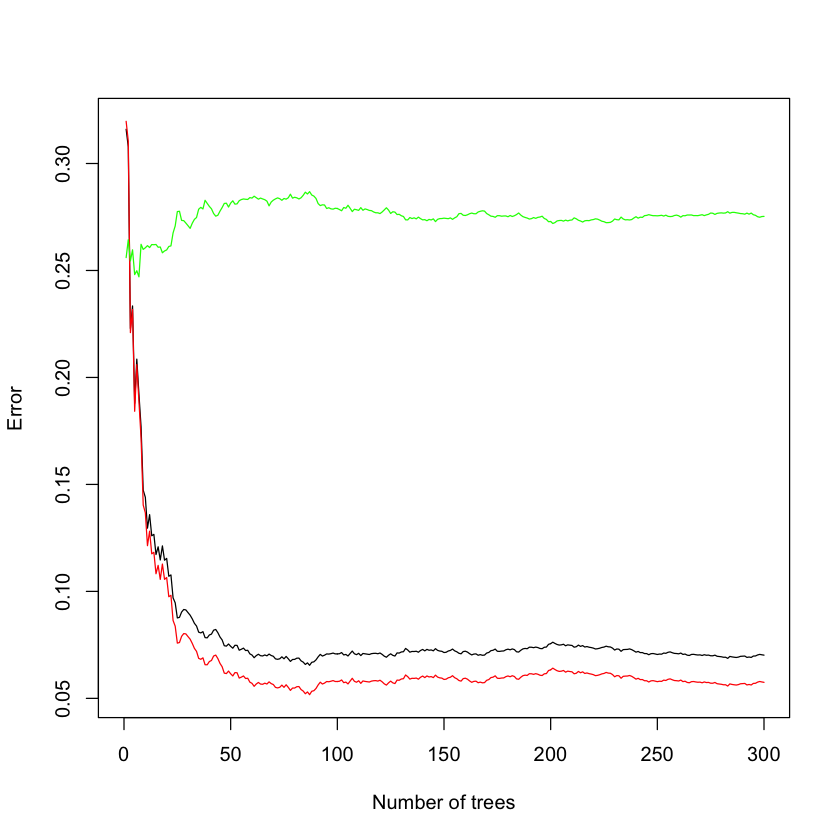

In [10]:
# plot the error rate
tmp = rf.model$err.rate
plot(c(0, rf.model$ntree), range(tmp), type="n",
     xlab = "Number of trees", ylab="Error")
lines(tmp[,1], col="black")
lines(tmp[,2], col="red")
lines(tmp[,3], col="green")

In [11]:
# calculate log-loss
test.y.hat = predict(rf.model, test, type="prob")[, 2]
test.y.hat = scale(test.y.hat)

# # make submission file
# TEST_predict$prob = test.y.hat
# write.table(TEST_predict, './mysubmission1.txt', row.names=FALSE, sep=',')

In [12]:
#######################################################
# temporarily code
train.y.hat = predict(rf.model, train, type="prob")[, 2]
train.y.hat = scale(train.y.hat)

train.y = train$loan_status

train.loss = -sum(train.y * log(train.y.hat)) / length(train.y)
test.loss = -sum(test.y * log(test.y.hat)) / length(test.y)

cat('train loss\t', train.loss, '\n')
cat('test loss\t', test.loss, '\n')

train loss	 0.02544473 
test loss	 0.02511468 


# XGBoost

In [13]:
train.m.y = train$loan_status
train.m.x = train[, -which(names(train) == "loan_status")]
train.m.x = apply(train.m.x, 2, as.numeric)

test.m.x = test
test.m.x = apply(test.m.x, 2, as.numeric)
ratio = as.integer(length(which(train.y == 0)) / length(which(train.y == 1)))

In [14]:
# fit the model
start.time = Sys.time()  # get time information

bst = xgboost(data=train.m.x, label=train.m.y, max.depth=6, eta=0.3, nrounds=100, 
              scale_pos_weight=ratio, objective="binary:logistic", verbose=F)

end.time = Sys.time()
cat("XGBoost Model\n")
cat('Start time:\t', as.character(start.time), '\n')
cat('End time:\t', as.character(end.time), '\n')
cat('Total time:\t', end.time - start.time, '\n')

XGBoost Model
Start time:	 2017-04-06 14:14:43 
End time:	 2017-04-06 14:52:25 
Total time:	 37.69788 


In [15]:
# calculate log-loss
test.y.hat = predict(bst, test.m.x)
test.y.hat = scale(test.y.hat)

# # make submission file
# TEST_predict$prob = test.y.hat
# write.table(TEST_predict, './mysubmission1.txt', row.names=FALSE, sep=',')

In [16]:
#######################################################
# temporarily code
train.y.hat = predict(bst, train.m.x)
train.y.hat = scale(train.y.hat)

train.y = train$loan_status

train.loss = -sum(train.y * log(train.y.hat)) / length(train.y)
test.loss = -sum(test.y * log(test.y.hat)) / length(test.y)

cat('train loss\t', train.loss, '\n')
cat('test loss\t', test.loss, '\n')

train loss	 0.01645519 
test loss	 0.02023472 


# Total Used Time

In [17]:
# get the used time information
all.end.time = Sys.time()
cat("All running time\n")
cat('Start time:\t', as.character(all.start.time), '\n')
cat('End time:\t', as.character(all.end.time), '\n')
cat('Total time:\t', all.end.time - all.start.time, '\n')

All running time
Start time:	 2017-04-06 13:04:23 
End time:	 2017-04-06 14:53:30 
Total time:	 1.818629 
